# Imports

In [1]:
import gc, pickle, re, json

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_seq_items', 1000)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Dropout, SpatialDropout1D

import matplotlib.pyplot as plt 
%matplotlib inline

/home/kaushik/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# UDFs

In [2]:
# Extract meta into features
def meta_to_features(df):
    for index, row in df.iterrows():
        meta = row.meta
        num_entries_per_key_in_row = {}

        for item in meta:
            key = item['key']
            value = item['value']

            if key not in num_entries_per_key_in_row.keys():
                num_entries_per_key_in_row[key] = 1
            else:
                num_entries_per_key_in_row[key] += 1

            key = f'{key}_{num_entries_per_key_in_row[key]}'
            if key not in df.columns:
                df[key] = None

            df.loc[index, key] = value

def reomve_stopwords(df, colname):
    en_stops = set(stopwords.words('english'))

    for index, row in df.iterrows():
        words = word_tokenize(row[colname]) 
        words = [w for w in words if not w in en_stops]
        df.loc[index, colname] = str(' '.join(words))

# Load the data

In [3]:
tweet_file_path = 'data/alltweets.json' 
other_file_path = 'data/allothers.json'

In [4]:
with open(other_file_path, encoding="utf8") as data_file:    
    data = json.load(data_file)

#with open(tweet_file_path, encoding="utf8") as data_file:    
#    data.extend(json.load(data_file))

data

[{'article_type': 'Product Review',
  'content': 'The best of all...',
  'date': '2005-01-31T18:30:00.000Z',
  'id': '00765d7b-b207-4f58-9446-4ec97a3b9b36',
  'image_url': None,
  'is_rejected': False,
  'is_reviewed': True,
  'is_upload_reqd': False,
  'last_tagged_date': None,
  'link': 'https://www.thetoptens.com/i/#kent-424498',
  'meta': [{'key': 'Brand', 'value': 'Kent'},
   {'key': 'Product Category', 'value': 'Cigarette'},
   {'key': 'Quality / Overall', 'value': 'best'}],
  'review_date': '2018-11-08T10:26:45.655Z',
  'sentiment': 'Very Positive',
  'source': 'The Top Tens',
  'title': 'Kent: The best of all...'},
 {'article_type': 'Product Review',
  'content': 'Best cigarette of all times',
  'date': '2005-01-31T18:30:00.000Z',
  'id': '010d85b1-09fc-4eab-940a-997f6c5da7cd',
  'image_url': None,
  'is_rejected': False,
  'is_reviewed': True,
  'is_upload_reqd': False,
  'last_tagged_date': None,
  'link': 'https://www.thetoptens.com/cigarette-brands/marlboro-41004.asp',
  'm

In [5]:
df_raw = pd.DataFrame(data)
df_raw.head()

,article_type,content,date,id,image_url,is_rejected,is_reviewed,is_upload_reqd,last_tagged_date,link,meta,review_date,sentiment,source,title
0,Product Review,The best of all...,2005-01-31T18:30:00.000Z,00765d7b-b207-4f58-9446-4ec97a3b9b36,None,False,True,False,None,https://www.thetoptens.com/i/#kent-424498,"[{'key': 'Brand', 'value': 'Kent'}, {'key': 'P...",2018-11-08T10:26:45.655Z,Very Positive,The Top Tens,Kent: The best of all...
1,Product Review,Best cigarette of all times,2005-01-31T18:30:00.000Z,010d85b1-09fc-4eab-940a-997f6c5da7cd,None,False,True,False,None,https://www.thetoptens.com/cigarette-brands/ma...,"[{'key': 'Brand', 'value': 'Marlboro'}, {'key'...",2018-11-08T10:28:00.027Z,Very Positive,The Top Tens,Marlboro: Best cigarette of all times
2,Product Review,As best as it's,2005-01-31T18:30:00.000Z,001790de-bf8f-473b-8247-8372a6569c9a,None,False,True,False,None,https://www.thetoptens.com/i/#camel-41007,"[{'key': 'Brand', 'value': 'Camel'}, {'key': '...",2018-11-08T10:28:27.142Z,Very Positive,The Top Tens,Camel: As best as it's
3,Product Review,Camels are the best cigarette that I have ever...,2005-01-31T18:30:00.000Z,01b7002c-dad0-420e-a2dc-cc12fe75b175,None,False,True,False,None,https://www.thetoptens.com/i/#camel-41007,"[{'key': 'Brand', 'value': 'Camel'}, {'key': '...",2018-11-08T10:28:48.621Z,Very Positive,The Top Tens,Camel: Camels are the best cigarette that I ha...
4,Product Review,Dunhill swich is the best,2005-01-31T18:30:00.000Z,00436e38-b775-43e1-9348-272e433f12bb,None,False,True,False,None,https://www.thetoptens.com/i/#dunhill-351703,"[{'key': 'Brand', 'value': 'Dunhill'}, {'key':...",2018-11-08T10:29:45.334Z,Very Positive,The Top Tens,Dunhill: Dunhill swich is the best


In [6]:
with open('data/df_raw_non_twitter.pkl', 'wb') as f:
    pickle.dump(df_raw, f)

# Feature engineering

In [7]:
with open('data/df_raw_non_twitter.pkl', 'rb') as f:
    df_raw = pickle.load(f)

In [8]:
df = df_raw.copy()

In [9]:
df = df[df.is_reviewed == True]
df.shape

(5307, 15)

In [60]:
df.loc[df.sentiment=='No Sentiment', 'content'].iloc[0]

'Moved to the UK from Chicago and the cigs in London tasted awful being after burning through my carton of Camel filters. Took awhile, but everything about Dunhill is excellent. Tobacco quality, look/feel, burn rate, and most important is the unique sweety taste.'

In [10]:
df.content = df.title + " " + df.content
df.drop('title', axis=1, inplace=True)
df.head()

,article_type,content,date,id,image_url,is_rejected,is_reviewed,is_upload_reqd,last_tagged_date,link,meta,review_date,sentiment,source
0,Product Review,Kent: The best of all... The best of all...,2005-01-31T18:30:00.000Z,00765d7b-b207-4f58-9446-4ec97a3b9b36,None,False,True,False,None,https://www.thetoptens.com/i/#kent-424498,"[{'key': 'Brand', 'value': 'Kent'}, {'key': 'P...",2018-11-08T10:26:45.655Z,Very Positive,The Top Tens
1,Product Review,Marlboro: Best cigarette of all times Best cig...,2005-01-31T18:30:00.000Z,010d85b1-09fc-4eab-940a-997f6c5da7cd,None,False,True,False,None,https://www.thetoptens.com/cigarette-brands/ma...,"[{'key': 'Brand', 'value': 'Marlboro'}, {'key'...",2018-11-08T10:28:00.027Z,Very Positive,The Top Tens
2,Product Review,Camel: As best as it's As best as it's,2005-01-31T18:30:00.000Z,001790de-bf8f-473b-8247-8372a6569c9a,None,False,True,False,None,https://www.thetoptens.com/i/#camel-41007,"[{'key': 'Brand', 'value': 'Camel'}, {'key': '...",2018-11-08T10:28:27.142Z,Very Positive,The Top Tens
3,Product Review,Camel: Camels are the best cigarette that I ha...,2005-01-31T18:30:00.000Z,01b7002c-dad0-420e-a2dc-cc12fe75b175,None,False,True,False,None,https://www.thetoptens.com/i/#camel-41007,"[{'key': 'Brand', 'value': 'Camel'}, {'key': '...",2018-11-08T10:28:48.621Z,Very Positive,The Top Tens
4,Product Review,Dunhill: Dunhill swich is the best Dunhill swi...,2005-01-31T18:30:00.000Z,00436e38-b775-43e1-9348-272e433f12bb,None,False,True,False,None,https://www.thetoptens.com/i/#dunhill-351703,"[{'key': 'Brand', 'value': 'Dunhill'}, {'key':...",2018-11-08T10:29:45.334Z,Very Positive,The Top Tens


In [11]:
#df.iloc[11105, :].meta
#df.iloc[11106, :].meta
#df = df.iloc[11105:11107, :]
#df.head()

In [12]:
# Extract meta into features
meta_to_features(df)
df.drop('meta', axis=1, inplace=True)
df.head()

,article_type,content,date,id,image_url,is_rejected,is_reviewed,is_upload_reqd,last_tagged_date,link,review_date,sentiment,source,Brand_1,Product Category_1,Quality / Overall_1,Product_1,Flavour_1,Smell_1,Design_1,Quality / Overall_2,Burn Rate_1,Brand_2,Country / Region_1,Key Phrase_1,Strength_1,Filter_1,Packaging_1,Taste_1,Burn Rate_2,Brand_3,Key Phrase_2,Taste_2,Flavour_2,Price_1,Brand_4,Brand_5,Brand_6,Body_1,Product_2,Product_3,Product_4,Packaging_2,Strength_2,Design_2,Subcategory_1,Flavour_3,Quality / Overall_3,Price_2,Filter_2,Body_2,Taste_3,Brand_7,Brand_8,Brand_9,Strength_3,Company_1,Brand_10,Body_3,Quality / Overall_4,Smell_2,Product Category_2,Quality / Overall_5,Rating_1,Key Phrase_3,Product_5,Product_6,Product Category_3,Product Category_4,Subcategory_2,Country / Region_2,Product_7,Country / Region_3,Filter_3,Flavour_4,Key Phrase_4,Battery and charging_1,Service_1,Flavour_5,Flavour_6,Flavour_7,Flavour_8,Flavour_9,Flavour_10,Flavour_11,Flavour_12,Flavour_13,Puff Count_1,Puff Count_2,Puff Count_3,Service_2,Company_2,Packaging_3,Burn Rate_3,Strength_4,Price_3,Battery and charging_2,Taste_4,Smell_3,Brand_11,Brand_12,Brand_13,Country / Region_4,Lag Time_1,Product_8,Country / Region_5,Country / Region_6,Country / Region_7,Country / Region_8,Country / Region_9,Country / Region_10,Country / Region_11,Country / Region_12,Country / Region_13,Country / Region_14,Business news- Others_1,Business news- Advertising_1,Brand_14,Brand_15,Brand_16,Brand_17,Brand_18,Brand_19,Brand_20,Brand_21,Brand_22,Brand_23,Brand_24,Key Phrase_5,Key Phrase_6,Key Phrase_7,Tobacco control- Plain packaging_1,Tobacco control- Regulatory acts_1,Tobacco control- Regulatory acts_2,Tobacco control- Regulatory acts_3,Tobacco control- Regulatory acts_4,Company_3,Company_4,Company_5,Company_6,Illicit trade_1,Illicit trade_2,Illicit trade_3,Business news- Advertising_2,Business news- Advertising_3,Business news- Advertising_4,Business news- Advertising_5,Tobacco control- Pricing and taxes_1,Government / Regulatory_1,Product_9,Product_10,Product_11,Product_12,Product_13,Product_14,Product_15,Product_16,Product_17,Battery and charging_3,Battery and charging_4,Subcategory_3,Tobacco control- Social Media_1,Design_3,Design_4,Filter_4,Quality / Overall_6,Smell_4,Strength_5,Strength_6,Filter_5
0,Product Review,Kent: The best of all... The best of all...,2005-01-31T18:30:00.000Z,00765d7b-b207-4f58-9446-4ec97a3b9b36,None,False,True,False,None,https://www.thetoptens.com/i/#kent-424498,2018-11-08T10:26:45.655Z,Very Positive,The Top Tens,Kent,Cigarette,best,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,Product Review,Marlboro: Best cigarette of all times Best cig...,2005-01-31T18:30:00.000Z,010d85b1-09fc-4eab-940a-997f6c5da7cd,None,False,True,False,None,https://www.thetoptens.com/cigarette-brands/ma...,2018-11-08T10:28:00.027Z,Very Positive,The Top Tens,Marlboro,Cigarette,best,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None

In [13]:
df.content = df.content.apply(lambda x: x.lower())
df.content = df.content.apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))
reomve_stopwords(df, 'content')
df.head()

,article_type,content,date,id,image_url,is_rejected,is_reviewed,is_upload_reqd,last_tagged_date,link,review_date,sentiment,source,Brand_1,Product Category_1,Quality / Overall_1,Product_1,Flavour_1,Smell_1,Design_1,Quality / Overall_2,Burn Rate_1,Brand_2,Country / Region_1,Key Phrase_1,Strength_1,Filter_1,Packaging_1,Taste_1,Burn Rate_2,Brand_3,Key Phrase_2,Taste_2,Flavour_2,Price_1,Brand_4,Brand_5,Brand_6,Body_1,Product_2,Product_3,Product_4,Packaging_2,Strength_2,Design_2,Subcategory_1,Flavour_3,Quality / Overall_3,Price_2,Filter_2,Body_2,Taste_3,Brand_7,Brand_8,Brand_9,Strength_3,Company_1,Brand_10,Body_3,Quality / Overall_4,Smell_2,Product Category_2,Quality / Overall_5,Rating_1,Key Phrase_3,Product_5,Product_6,Product Category_3,Product Category_4,Subcategory_2,Country / Region_2,Product_7,Country / Region_3,Filter_3,Flavour_4,Key Phrase_4,Battery and charging_1,Service_1,Flavour_5,Flavour_6,Flavour_7,Flavour_8,Flavour_9,Flavour_10,Flavour_11,Flavour_12,Flavour_13,Puff Count_1,Puff Count_2,Puff Count_3,Service_2,Company_2,Packaging_3,Burn Rate_3,Strength_4,Price_3,Battery and charging_2,Taste_4,Smell_3,Brand_11,Brand_12,Brand_13,Country / Region_4,Lag Time_1,Product_8,Country / Region_5,Country / Region_6,Country / Region_7,Country / Region_8,Country / Region_9,Country / Region_10,Country / Region_11,Country / Region_12,Country / Region_13,Country / Region_14,Business news- Others_1,Business news- Advertising_1,Brand_14,Brand_15,Brand_16,Brand_17,Brand_18,Brand_19,Brand_20,Brand_21,Brand_22,Brand_23,Brand_24,Key Phrase_5,Key Phrase_6,Key Phrase_7,Tobacco control- Plain packaging_1,Tobacco control- Regulatory acts_1,Tobacco control- Regulatory acts_2,Tobacco control- Regulatory acts_3,Tobacco control- Regulatory acts_4,Company_3,Company_4,Company_5,Company_6,Illicit trade_1,Illicit trade_2,Illicit trade_3,Business news- Advertising_2,Business news- Advertising_3,Business news- Advertising_4,Business news- Advertising_5,Tobacco control- Pricing and taxes_1,Government / Regulatory_1,Product_9,Product_10,Product_11,Product_12,Product_13,Product_14,Product_15,Product_16,Product_17,Battery and charging_3,Battery and charging_4,Subcategory_3,Tobacco control- Social Media_1,Design_3,Design_4,Filter_4,Quality / Overall_6,Smell_4,Strength_5,Strength_6,Filter_5
0,Product Review,kent best best,2005-01-31T18:30:00.000Z,00765d7b-b207-4f58-9446-4ec97a3b9b36,None,False,True,False,None,https://www.thetoptens.com/i/#kent-424498,2018-11-08T10:26:45.655Z,Very Positive,The Top Tens,Kent,Cigarette,best,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,Product Review,marlboro best cigarette times best cigarette t...,2005-01-31T18:30:00.000Z,010d85b1-09fc-4eab-940a-997f6c5da7cd,None,False,True,False,None,https://www.thetoptens.com/cigarette-brands/ma...,2018-11-08T10:28:00.027Z,Very Positive,The Top Tens,Marlboro,Cigarette,best,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Non

In [14]:
with open('data/df_non_twitter.pkl', 'wb') as f:
    pickle.dump(df, f)

# Filter

In [15]:
with open('data/df_non_twitter.pkl', 'rb') as f:
    df = pickle.load(f)

In [16]:
print(set(df.sentiment))
print(len(df))
df.sentiment.value_counts()

{'Very Positive', 'Positive', 'Very Negative', 'No Sentiment', 'Negative', 'Neutral'}
5307


Very Positive    2127
No Sentiment     1757
Positive          741
Negative          273
Very Negative     220
Neutral           189
Name: sentiment, dtype: int64

In [18]:
#df = df.loc[df.sentiment != 'No Sentiment']
df.loc[df.sentiment=='No Sentiment', 'sentiment'] = 'Neutral'

df.loc[df.sentiment=='Very Positive', 'sentiment'] = 'Positive'
df.loc[df.sentiment=='Very Negative', 'sentiment'] = 'Negative'

# Extract test data

In [19]:
y = df['sentiment'].copy()
X = df.drop('sentiment', axis=1).copy()

n_levels = len(set(y))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
len(X_train)
len(X_test)

3714

1593

# Model

## Hype-parameters

In [10]:
max_vocab_size = 5000
max_seq_len = 500

In [11]:
embedding_size = 64
lstm_out = 128
spatial_dropout_rate = 0.4
dropout = 0.2
recurrent_dropout = 0.2
output_units = n_levels

## Preprocess

In [12]:
tokenizer = Tokenizer(num_words=max_vocab_size, split=' ')
tokenizer.fit_on_texts(X_train.content.values)

## Prepare for keras

In [23]:
y_train = pd.get_dummies(y_train).values.copy()

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train.content.values), maxlen=max_seq_len)
X_train.shape

(3714, 500)

## Build architecture

In [25]:
model = Sequential()
model.add(Embedding(max_vocab_size, embedding_size, input_length=max_seq_len))
model.add(SpatialDropout1D(spatial_dropout_rate))
model.add(LSTM(lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout))
model.add(Dense(output_units, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 64)           320000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 500, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 419,203
Trainable params: 419,203
Non-trainable params: 0
_________________________________________________________________
None


## Split

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
len(X_train)
len(X_val)

3342

372

## Fit

In [27]:
batch_size = 32
epochs = 4

In [28]:
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          class_weight='balanced',
          epochs=epochs, batch_size=batch_size, 
          verbose=2);

Train on 3342 samples, validate on 372 samples
Epoch 1/4
 - 63s - loss: 0.8697 - acc: 0.5829 - val_loss: 0.7718 - val_acc: 0.6452
Epoch 2/4
 - 70s - loss: 0.6693 - acc: 0.7101 - val_loss: 0.7226 - val_acc: 0.6586
Epoch 3/4
 - 66s - loss: 0.5392 - acc: 0.7741 - val_loss: 0.7192 - val_acc: 0.6909
Epoch 4/4
 - 65s - loss: 0.4349 - acc: 0.8238 - val_loss: 0.6910 - val_acc: 0.6935


In [29]:
model.save('data/model_non_twitter.h5')

# Predict

In [30]:
model = load_model('data/model_non_twitter.h5')

## Evaluate

In [31]:
y_test_dummies = pd.get_dummies(y_test)
y_test = y_test_dummies.values.copy()

X_test = pad_sequences(tokenizer.texts_to_sequences(X_test.content.values), maxlen=max_seq_len)
X_test.shape

(1593, 500)

In [32]:
scores = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.7269303202629089


## Analyze

In [35]:
pred = model.predict_classes(X_test)
pred[:5]
y_test_dummies.head()

array([2, 2, 2, 2, 2])

,Negative,Neutral,Positive
5670,0,0,1
13493,0,0,1
5419,0,0,1
20644,0,1,0
5302,0,0,1


In [36]:
y_test_classes = pd.DataFrame({'actual': y_test_dummies.columns[np.where(y_test_dummies != 0)[1]]}, 
                              index=y_test_dummies.index)
y_test_classes['pred'] = pred
y_test_classes.head()

,actual,pred
5670,Positive,2
13493,Positive,2
5419,Positive,2
20644,Neutral,2
5302,Positive,2


In [37]:
map_dummies = {}
code = 0

for col in y_test_dummies.columns:
    map_dummies[code] = col
    code += 1

y_test_classes['pred'] = y_test_classes['pred'].map(map_dummies)
y_test_classes.head()

,actual,pred
5670,Positive,Positive
13493,Positive,Positive
5419,Positive,Positive
20644,Neutral,Positive
5302,Positive,Positive


In [38]:
# Coarse mapping
'''
map_coarse_classes = {'Very Positive': 'Positive', 'Very Negative': 'Negative', 
                      'Negative': 'Negative', 'Positive': 'Positive', 'Neutral': 'Neutral', 
                      'No Sentiment': 'No Sentiment'}
y_test_classes['actual'] = y_test_classes['actual'].map(map_coarse_classes)
y_test_classes['pred'] = y_test_classes['pred'].map(map_coarse_classes)
y_test_classes.head()
'''

"\nmap_coarse_classes = {'Very Positive': 'Positive', 'Very Negative': 'Negative', \n                      'Negative': 'Negative', 'Positive': 'Positive', 'Neutral': 'Neutral', \n                      'No Sentiment': 'No Sentiment'}\ny_test_classes['actual'] = y_test_classes['actual'].map(map_coarse_classes)\ny_test_classes['pred'] = y_test_classes['pred'].map(map_coarse_classes)\ny_test_classes.head()\n"

In [39]:
print(classification_report(y_test_classes.actual, y_test_classes.pred))
print(pd.crosstab(y_test_classes.actual, y_test_classes.pred,
                  rownames=['True'], colnames=['Predicted'], margins=True))

             precision    recall  f1-score   support

   Negative       0.78      0.45      0.57       149
    Neutral       0.67      0.60      0.63       578
   Positive       0.75      0.86      0.80       866

avg / total       0.72      0.73      0.72      1593

Predicted  Negative  Neutral  Positive   All
True                                        
Negative         67       52        30   149
Neutral          17      347       214   578
Positive          2      120       744   866
All              86      519       988  1593


## Inspect

In [40]:
with open('data/df_raw_non_twitter.pkl', 'rb') as f:
    df_raw = pickle.load(f)

In [41]:
y_test_classes['correct'] = y_test_classes.apply(lambda row: row['actual']==row['pred'], axis=1)
y_test_classes.head()

,actual,pred,correct
5670,Positive,Positive,True
13493,Positive,Positive,True
5419,Positive,Positive,True
20644,Neutral,Positive,False
5302,Positive,Positive,True


In [42]:
y_test_classes = y_test_classes.merge(df_raw, how='inner', left_index=True, right_index=True)
y_test_classes.head()

,actual,pred,correct,article_type,content,date,id,image_url,is_rejected,is_reviewed,is_upload_reqd,last_tagged_date,link,meta,review_date,sentiment,source,title
5670,Positive,Positive,True,Product Review,"This is one of my favorites. Strong, with a go...",2015-10-28T18:30:00.000Z,769cae28-5a1e-492f-aa59-123914c2ada9,None,False,True,True,None,https://www.ciggiesworld.ch/product/gudang-gar...,"[{'key': 'Rating', 'value': '5'}, {'key': 'Bra...",2018-11-19T07:08:12.558Z,Very Positive,Ciggies World,Gudang Garam International Canned: This is one...
13493,Positive,Positive,True,Product Review,Strong as fuck!\n,2005-01-31T18:30:00.000Z,4dca0222-bc41-4c23-8f5a-6915e7683c5e,None,False,True,True,None,https://www.dutyfree.io/shop/classic-red/,"[{'key': 'Rating', 'value': '4'}, {'key': 'Pro...",2018-11-20T10:56:44.058Z,Positive,Dutyfree,Classic Red: Strong as fuck!\n
5419,Positive,Positive,True,Product Review,Arguably the most iconic clove cigarette out t...,2013-11-10T18:30:00.000Z,8bc4f980-d583-4167-835e-b2eba360c92e,None,False,True,True,None,https://www.ciggiesworld.ch/product/djarum-black/,"[{'key': 'Rating', 'value': '4'}, {'key': 'Bra...",2018-11-16T11:10:03.264Z,Positive,Ciggies World,Djarum Black: Arguably the most iconic clove c...
20644,Neutral,Positive,False,Discussion,,2017-02-01T18:30:00.000Z,19053927-5d99-466a-8a4d-bc12f935fd92,None,False,True,True,None,https://www.reddit.com/r/Cigarettes/comments/5...,"[{'key': 'Product Category', 'value': 'Cigaret...",2018-12-26T06:44:55.593Z,No Sentiment,Reddit,I haven't ever disliked a brand that I've trie...
5302,Positive,Positive,True,Product Review,"Sort of harsh, but the clove taste is great an...",2017-01-11T18:30:00.000Z,4655ca59-f27a-4663-bc58-4ed24cece758,None,False,True,True,None,https://www.ciggiesworld.ch/product/gudang-gar...,"[{'key': 'Rating', 'value': '5'}, {'key': 'Bra...",2018-11-13T10:40:01.102Z,Very Positive,Ciggies World,"Gudang Garam International: Sort of harsh, but..."


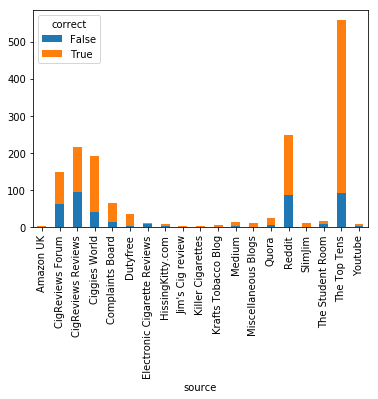

In [43]:
pd.crosstab(y_test_classes.source, y_test_classes.correct).plot(kind='bar', stacked=True);

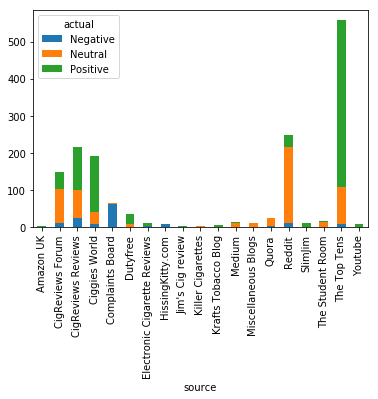

In [44]:
pd.crosstab(y_test_classes.source, y_test_classes.actual).plot(kind='bar', stacked=True);

### Incorrect

In [45]:
incorrect = y_test_classes[y_test_classes.correct == False]
incorrect.head(20)

,actual,pred,correct,article_type,content,date,id,image_url,is_rejected,is_reviewed,is_upload_reqd,last_tagged_date,link,meta,review_date,sentiment,source,title
20644,Neutral,Positive,False,Discussion,,2017-02-01T18:30:00.000Z,19053927-5d99-466a-8a4d-bc12f935fd92,None,False,True,True,None,https://www.reddit.com/r/Cigarettes/comments/5...,"[{'key': 'Product Category', 'value': 'Cigaret...",2018-12-26T06:44:55.593Z,No Sentiment,Reddit,I haven't ever disliked a brand that I've trie...
1794,Neutral,Positive,False,Product Review,"I ordered a carton of 99s from the states, you...",2005-01-31T18:30:00.000Z,6762b2ea-fc2e-4115-91bb-ce30983421c1,None,False,True,True,None,https://www.thetoptens.com/i/#camel-41007,"[{'key': 'Brand', 'value': 'Camel'}, {'key': '...",2018-11-19T05:13:34.573Z,No Sentiment,The Top Tens,Camel: I ordered a carton of 99s from the stat...
6224,Negative,Neutral,False,Product Review,Ordered several boxes of medium strength magni...,2013-04-14T18:30:00.000Z,e60ab183-973b-4205-ae15-f3e3512181ff,None,False,True,False,None,https://www.electroniccigarettesreviews.net/bl...,"[{'key': 'Flavour', 'value': 'Magnificent Ment...",2018-10-15T05:20:44.190Z,Very Negative,Electronic Cigarette Reviews,Blu: Did not offer replacement
4880,Negative,Positive,False,Product Review,cheap menthol taste.. i discovered that i’m no...,2015-11-11T18:30:00.000Z,1b85df7d-55e3-4e10-9046-6cd9d3d0518f,None,False,True,True,None,https://www.ciggiesworld.ch/product/djarum-bla...,"[{'key': 'Rating', 'value': '1'}, {'key': 'Bra...",2018-11-13T04:58:22.816Z,Very Negative,Ciggies World,Djarum Black Menthol: cheap menthol taste.. i ...
13539,Neutral,Positive,False,Discussion,,2018-09-22T18:30:00.000Z,83033b8c-c76f-4219-9888-513488c03db3,https://i.redd.it/mjj7yl5kytn11.jpg,False,True,True,None,https://www.reddit.com/r/Cigarettes/comments/9...,"[{'key': 'Brand', 'value': 'Camel'}, {'key': '...",2018-12-21T05:45:43.854Z,No Sentiment,Reddit,What's everybody smoking today?
36538,Neutral,Positive,False,Discussion,,2018-04-12T18:30:00.000Z,493dae53-99ec-47d5-97b7-b66e2ac635d7,https://i.redd.it/53z2a1fpftr01.jpg,False,True,True,None,https://www.reddit.com/r/Cigarettes/comments/8...,"[{'key': 'Brand', 'value': 'Export A'}, {'key'...",2019-01-03T07:58:23.091Z,No Sentiment,Reddit,As a Canadian smoker who has tried AS Blue and...
54317,Neutral,Positive,False,Discussion,I smoke Marlboro Slates because they are the b...,2017-01-22T18:30:00.000Z,3f6dad25-6fc1-4b08-97d0-6182acdad43a,None,False,True,False,None,https://www.cigreviews.com/forums/general-smok...,"[{'key': 'Brand', 'value': 'Marlboro'}, {'key'...",2018-10-22T10:18:01.497Z,Neutral,CigReviews Forum,Which cigarettes do you smoke and why? smoke M...
7462,Positive,Neutral,False,Product Review,I was smokin the 27 100's for awhile as soon a...,2012-09-30T18:30:00.000Z,17a65b9f-8b0b-4976-bfb8-ee6b28eea10f,None,False,True,True,None,https://www.cigreviews.com/view-review/Marlbor...,"[{'key': 'Rating', 'value': '5.0'}, {'key': 'S...",2018-12-26T10:07:33.623Z,Very Positive,CigReviews Reviews,Marlboro Special Blend (Black): I was smokin t...
11145,Negative,Positive,False,Product Review,These are not that enjoyable. To me the taste ...,2010-03-20T18:30:00.000Z,59a8b903-8617-4761-8f10-426d6106b934,None,False,True,True,None,https://www.cigreviews.com/view-review/Camel/656,"[{'key': 'Rating', 'value': '2.0'}, {'key': 'S...",2018-12-26T10:53:04.740Z,Negative,CigReviews Reviews,Camel Crush: These are not that enjoyable. To ...
40384,Positive,Neutral,False,Discussion,Comment: 13 (2018-12-29):\nWhen i ordered my f...,2018-12-28T18:30:00.000Z,59c8b0d0-795f-41ff-bec1-b62742ddeb2d,None,False,True,True,None,https://www.reddit.com/r/juul/comments/aac8zg/...,"[{'key': 'Brand', 'value': 'JUUL'}, {'key': 'P...",2019-01-17T10:01:56.446Z,Very Positive,Reddit,Comment thread 13: Juul support is awesome


In [46]:
incorrect.source.value_counts()

CigReviews Reviews              94
The Top Tens                    93
Reddit                          86
CigReviews Forum                62
Ciggies World                   41
Complaints Board                15
Electronic Cigarette Reviews     9
The Student Room                 8
Quora                            7
Medium                           5
Dutyfree                         4
HissingKitty.com                 3
Youtube                          3
Amazon UK                        2
Killer Cigarettes                2
SlimJim                          1
Name: source, dtype: int64

In [47]:
incorrect.loc[1079, 'content']
incorrect.loc[1079, 'title']
incorrect.loc[1079, 'meta']
incorrect.loc[1079, ['actual', 'pred']]
model.predict(pad_sequences(tokenizer.texts_to_sequences(df.loc[1079:1079, 'content'].values), 
                            maxlen=max_seq_len))

'Too light and expensive for me!'

'Marlboro: Too light and expensive for me!'

[{'key': 'Brand', 'value': 'Marlboro'},
 {'key': 'Product Category', 'value': 'Cigarette'},
 {'key': 'Strength', 'value': 'a little too light'},
 {'key': 'Price', 'value': 'Expensive'}]

actual    Negative
pred      Positive
Name: 1079, dtype: object

array([[0.0595977 , 0.25180337, 0.68859893]], dtype=float32)

In [49]:
incorrect.loc[6224, 'content']
incorrect.loc[6224, 'title']
incorrect.loc[6224, 'meta']
incorrect.loc[6224, ['actual', 'pred']]
model.predict(pad_sequences(tokenizer.texts_to_sequences(df.loc[6224:6224, 'content'].values), 
                            maxlen=max_seq_len))

'Ordered several boxes of medium strength magnificent menthol – flavor is more like the vanilla. Company will not take back due to it being a “consumable” and subject to tampering. Did not offer replacement or refund or anything. Simply told us to rub cartridge in hands to warm up and thump it on the table to improve the flavor. How does this change vanilla to menthol? Your guess is as good as mine!!!!!'

'Blu: Did not offer replacement'

[{'key': 'Flavour', 'value': 'Magnificent Menthol'},
 {'key': 'Flavour', 'value': 'Vanilla'},
 {'key': 'Strength', 'value': 'Medium'},
 {'key': 'Taste', 'value': 'like Vanilla'},
 {'key': 'Brand', 'value': 'Blu'},
 {'key': 'Service', 'value': 'No replacement or refund'},
 {'key': 'Rating', 'value': '3'},
 {'key': 'Product Category', 'value': 'E-cigarette'}]

actual    Negative
pred       Neutral
Name: 6224, dtype: object

array([[0.09234685, 0.6876865 , 0.2199666 ]], dtype=float32)

In [51]:
incorrect.loc[7462, 'content']
incorrect.loc[7462, 'title']
incorrect.loc[7462, 'meta']
incorrect.loc[7462, ['actual', 'pred']]
model.predict(pad_sequences(tokenizer.texts_to_sequences(df.loc[7462:7462, 'content'].values), 
                            maxlen=max_seq_len))

"I was smokin the 27 100's for awhile as soon as those came out but I tried the blacks shortly after they came out and found the flavor even more appealing than the 27's. I've been smokin blacks nonstop since. My buddy stays true to the reds so I personally think Marlboro has finally found their two finest"

"Marlboro Special Blend (Black): I was smokin the 27 100's for awhile as soon as those came"

[{'key': 'Rating', 'value': '5.0'},
 {'key': 'Strength', 'value': 'Strong'},
 {'key': 'Taste', 'value': 'Very Pleasant'},
 {'key': 'Price', 'value': 'Very Low'},
 {'key': 'Brand', 'value': 'Marlboro'},
 {'key': 'Product Category', 'value': 'Cigarette'},
 {'key': 'Product', 'value': 'Marlboro Special Blend (Black)'}]

actual    Positive
pred       Neutral
Name: 7462, dtype: object

array([[0.04811781, 0.8264444 , 0.12543783]], dtype=float32)

In [53]:
incorrect.loc[119, 'content']
incorrect.loc[119, 'title']
incorrect.loc[119, 'meta']
incorrect.loc[119, ['actual', 'pred']]
model.predict(pad_sequences(tokenizer.texts_to_sequences(df.loc[119:119, 'content'].values), 
                            maxlen=max_seq_len))

'So much smoother than Marlboros. Sweet smell with a sweet, smooth flavour.'

'Camel: So much smoother than Marlboros. Sweet smell with '

[{'key': 'Brand', 'value': 'Camel'},
 {'key': 'Brand', 'value': 'Marlboro'},
 {'key': 'Product Category', 'value': 'Cigarette'},
 {'key': 'Key Phrase', 'value': 'comparison'}]

actual     Neutral
pred      Positive
Name: 119, dtype: object

array([[0.00140934, 0.00935823, 0.9892324 ]], dtype=float32)

### Correct

In [54]:
correct = y_test_classes[y_test_classes.correct == True]
correct.head(20)

,actual,pred,correct,article_type,content,date,id,image_url,is_rejected,is_reviewed,is_upload_reqd,last_tagged_date,link,meta,review_date,sentiment,source,title
5670,Positive,Positive,True,Product Review,"This is one of my favorites. Strong, with a go...",2015-10-28T18:30:00.000Z,769cae28-5a1e-492f-aa59-123914c2ada9,None,False,True,True,None,https://www.ciggiesworld.ch/product/gudang-gar...,"[{'key': 'Rating', 'value': '5'}, {'key': 'Bra...",2018-11-19T07:08:12.558Z,Very Positive,Ciggies World,Gudang Garam International Canned: This is one...
13493,Positive,Positive,True,Product Review,Strong as fuck!\n,2005-01-31T18:30:00.000Z,4dca0222-bc41-4c23-8f5a-6915e7683c5e,None,False,True,True,None,https://www.dutyfree.io/shop/classic-red/,"[{'key': 'Rating', 'value': '4'}, {'key': 'Pro...",2018-11-20T10:56:44.058Z,Positive,Dutyfree,Classic Red: Strong as fuck!\n
5419,Positive,Positive,True,Product Review,Arguably the most iconic clove cigarette out t...,2013-11-10T18:30:00.000Z,8bc4f980-d583-4167-835e-b2eba360c92e,None,False,True,True,None,https://www.ciggiesworld.ch/product/djarum-black/,"[{'key': 'Rating', 'value': '4'}, {'key': 'Bra...",2018-11-16T11:10:03.264Z,Positive,Ciggies World,Djarum Black: Arguably the most iconic clove c...
5302,Positive,Positive,True,Product Review,"Sort of harsh, but the clove taste is great an...",2017-01-11T18:30:00.000Z,4655ca59-f27a-4663-bc58-4ed24cece758,None,False,True,True,None,https://www.ciggiesworld.ch/product/gudang-gar...,"[{'key': 'Rating', 'value': '5'}, {'key': 'Bra...",2018-11-13T10:40:01.102Z,Very Positive,Ciggies World,"Gudang Garam International: Sort of harsh, but..."
54643,Positive,Positive,True,Discussion,"Pretty new to smoking cigs, started off with A...",2015-05-07T18:30:00.000Z,0f2a3ca1-bc66-43cd-8dd7-bf30f40c19bb,None,False,True,True,None,https://www.cigreviews.com/forums/general-smok...,"[{'key': 'Brand', 'value': 'American Spirit'},...",2018-11-08T09:51:36.154Z,Positive,CigReviews Forum,Which cigarettes do you smoke and why? Camel T...
58458,Negative,Negative,True,Product Review,I have been smoking Bond Streets for quite som...,2018-01-29T18:30:00.000Z,7c0a5a1f-def5-4c79-be29-512e905afbd8,None,False,True,True,None,https://www.complaintsboard.com/complaints/bon...,"[{'key': 'Country / Region', 'value': 'Austral...",2018-10-24T07:24:54.529Z,Negative,Complaints Board,Bond Street Cigarettes / tobacco falling out
1059,Neutral,Neutral,True,Product Review,Tried Marlboro but I prefer Camels.,2005-01-31T18:30:00.000Z,a5f09a8f-6bd9-473a-a5ba-bb276f2c3b32,None,False,True,True,None,https://www.thetoptens.com/i/#camel-41007,"[{'key': 'Brand', 'value': 'Camel'}, {'key': '...",2018-11-20T11:15:38.002Z,No Sentiment,The Top Tens,Camel: Tried Marlboro but I prefer Camels.
6711,Positive,Positive,True,Product Review,I have smoked benson & hedges gold for a long ...,2011-11-03T18:30:00.000Z,0b392c02-1540-4e0a-a233-ca86cd69bae5,None,False,True,True,None,https://www.cigreviews.com/view-review/Benson-...,"[{'key': 'Rating', 'value': '5.0'}, {'key': 'S...",2018-12-21T11:20:36.640Z,Very Positive,CigReviews Reviews,Benson and Hedges Gold: I have smoked benson &...
1982,Positive,Positive,True,Product Review,I smoke Marlboro red 100's.After a cigarette I...,2005-01-31T18:30:00.000Z,74827738-e78d-4879-8712-c1b7bc45085b,None,False,True,True,None,https://www.thetoptens.com/cigarette-brands/ma...,"[{'key': 'Brand', 'value': 'Marlboro'}, {'key'...",2018-11-19T08:11:12.944Z,Very Positive,The Top Tens,Marlboro: I smoke Marlboro red 100's.After a c...
55744,Negative,Negative,True,Product Review,"Hi, I have just returned from a trip to Cape Y...",2017-01-06T18:30:00.000Z,c7a5bfc9-99a8-41b7-a9e7-4a7e0c0b0b28,None,False,True,True,None,https://www.complaintsboard.com/complaints/phi...,"[{'key': 'Country / Region', 'value': 'Austral...",2018-10-24T04:19:53.541Z,Very Negative,Complaints Board,Peter Jackson Gold- I have never experienced s...


In [55]:
correct.source.value_counts()

The Top Tens                    464
Reddit                          162
Ciggies World                   150
CigReviews Reviews              121
CigReviews Forum                 87
Complaints Board                 50
Dutyfree                         33
Quora                            19
Miscellaneous Blogs              13
SlimJim                          12
Medium                            9
The Student Room                  8
HissingKitty.com                  7
Krafts Tobacco Blog               6
Jim's Cig review                  5
Youtube                           5
Electronic Cigarette Reviews      3
Amazon UK                         2
Killer Cigarettes                 2
Name: source, dtype: int64

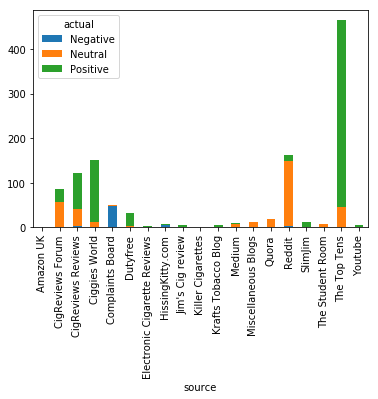

In [56]:
pd.crosstab(correct.source, correct.actual).plot(kind='bar', stacked=True);

In [57]:
correct.loc[5670, 'content']
correct.loc[5670, 'title']
correct.loc[5670, 'meta']
correct.loc[5670, ['actual', 'pred']]

'This is one of my favorites. Strong, with a good balance of tobacco and clove.'

'Gudang Garam International Canned: This is one of my favorites. Strong, with a good b'

[{'key': 'Rating', 'value': '5'},
 {'key': 'Brand', 'value': 'Gudang Garam'},
 {'key': 'Product Category', 'value': 'Cigarette'},
 {'key': 'Product', 'value': 'Gudang Garam International'},
 {'key': 'Quality / Overall', 'value': 'favourite'},
 {'key': 'Quality / Overall', 'value': 'good balance'},
 {'key': 'Strength', 'value': 'Strong'}]

actual    Positive
pred      Positive
Name: 5670, dtype: object

In [58]:
correct.loc[58458, 'content']
correct.loc[58458, 'title']
correct.loc[58458, 'meta']
correct.loc[58458, ['actual', 'pred']]

'I have been smoking Bond Streets for quite sometime now and had little to no issues with the product. However, after purchasing a pack of Bond Street Blue 25 recently, most if not all of the cigarettes had some of the tobacco falling out or loose already. A few having less than half of the tobacco fallen out. I am a loyal Bond Street smoker and was not impressed by the quality of the cigarettes.\nAttached I have a picture of the two worst cigarettes from the deck and the other photo is of the amount of tobacco at the bottom of the deck.\n\nPlease contact me on simonmstrachan@gmail.com\nThanks,\nSimon Strachan'

'Bond Street Cigarettes / tobacco falling out'

[{'key': 'Country / Region', 'value': 'Australia'},
 {'key': 'Brand', 'value': 'Bond Street Smokes'},
 {'key': 'Product', 'value': 'Bond Street blue 25'},
 {'key': 'Rating', 'value': '1'},
 {'key': 'Product Category', 'value': 'Cigarette'},
 {'key': 'Quality / Overall', 'value': 'Tobacco fell out'},
 {'key': 'Company', 'value': 'Altria'}]

actual    Negative
pred      Negative
Name: 58458, dtype: object

In [59]:
correct.loc[1059, 'content']
correct.loc[1059, 'title']
correct.loc[1059, 'meta']
correct.loc[1059, ['actual', 'pred']]

'Tried Marlboro but I prefer Camels.'

'Camel: Tried Marlboro but I prefer Camels.'

[{'key': 'Brand', 'value': 'Camel'},
 {'key': 'Brand', 'value': 'Marlboro'},
 {'key': 'Product Category', 'value': 'Cigarette'}]

actual    Neutral
pred      Neutral
Name: 1059, dtype: object